## Sea ice classification with GMM (pixel based) - unsupervised
IPython notebook demo of the Gaussian Mixture Model (GMM) algorithm for sea ice classification (pixel based)
As part of the 2016 XSEDE Polar Hackathon. 

Contributing authors: Alek Petty, Andrew Barrett, Xin Miao, Phil McDowell, Vivek Balasubramanian

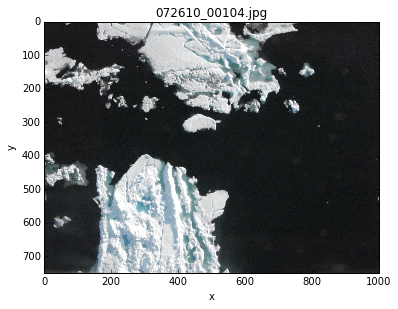

In [59]:
%matplotlib inline
from scipy import misc
from pylab import *
from skimage.segmentation import mark_boundaries

trainingPath="../../../../DATA/IMAGERY/XIN/TRAINING/"
filePath = "../../../../DATA/IMAGERY/XIN/"

iceTypes=4
imageName='072610_00104.jpg'

img = misc.imread(filePath+imageName)
fig1 = figure(figsize=(6, 6))
title(imageName)
xlabel('x')
ylabel('y')
imshow(img)
plt.show()

In [60]:
#load and apply the Gaussian Mixture Model (GMM) classification scheme to one sea ice image.
from sklearn import mixture
#n_components is the number of surface types we want to find.
gmix = mixture.GMM(n_components=iceTypes, covariance_type='full')
#fit to image
gmix.fit(img.reshape((img.shape[0]*img.shape[1],3)))
#extract class means and cov
#this can be made a 'supervised' method by setting .means_ and .covars_ to mean/cov of samples
#mean = gmix.means_
#cov = gmix.covars_

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=4, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

In [61]:
def sortGMM(gmixT):
    # Sort the classification by mean spectral values 
    # For consistency with later classifications
    sort_indices = gmixT.means_.argsort(axis = 0)
    order = sort_indices[:, 0]
    #print('\norder:', order)
    gmixT.means_ = gmixT.means_[order,:]    
    gmixT.covars_ = gmixT.covars_[order, :]
    a=[gmixT.weights_[x] for x in order]
    gmixT.weights_=a
    return gmixT

gmix=sortGMM(gmix)
gmix.means_
# show that the means are now in ascending order

array([[  23.25769569,   25.46407673,   27.04704448],
       [  83.46439325,   94.69337062,   96.62208903],
       [ 171.3522584 ,  187.23381164,  195.2171984 ],
       [ 216.31859021,  217.8088947 ,  219.70618889]])

In [62]:
def image_rgb_histogram(img, means, bins=50, figsize=(7,10)):

    # Convert to a numpy array
    # Expects a numpy array but also deals with a list
    ndimg = np.asarray(img)
    
    # Check that img is greater than 1D
    if ((ndimg.ndim != 2) and (ndimg.ndim != 3)):
        print "% image_rgb_histogram: expects img to be 2D or 3D"
        return
    
    # Extract rgb info
    #  - reshape to n by 3 array
    if (ndimg.ndim == 3):
        tdimg = ndimg.reshape(ndimg.shape[0]*ndimg.shape[1],-1)
    else:
        tdimg = ndimg
        
    r = tdimg[:,0]
    g = tdimg[:,1]
    b = tdimg[:,2]
    
    fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=figsize)
    ax[0].set_xlim(0,255)
    ax[0].set_ylim(0,0.05)
    ax[2].set_xlabel('BV')
    n0, bins0, patches0 = ax[0].hist(r, bins=bins, normed=1, facecolor='red', alpha=0.75)
    n1, bins1, patches1 = ax[1].hist(g, bins=bins, normed=1, facecolor='green', alpha=0.75)
    n2, bins2, patches2 = ax[2].hist(b, bins=bins, normed=1, facecolor='blue', alpha=0.75)

    for i in xrange(size(gmix.means_[:, 0])):
        ax[0].axvline(x=gmix.means_[i, 0], color='r', linewidth=2.)
        ax[1].axvline(x=gmix.means_[i, 1], color='g', linewidth=2.)
        ax[2].axvline(x=gmix.means_[i, 2], color='b', linewidth=2.)
    ax[0].set_title('RGB brightness histogram of image:'+imageName)
    fig.subplots_adjust(hspace=0)

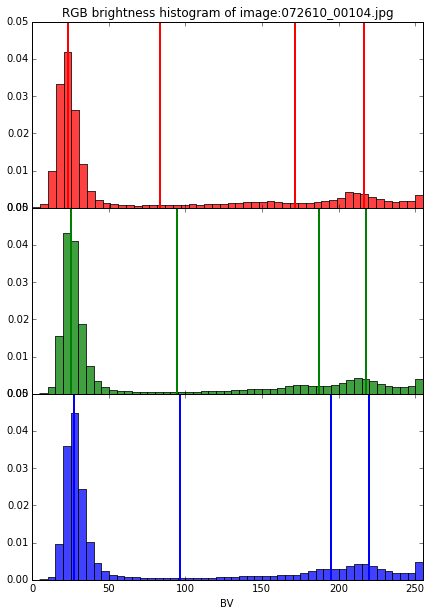

In [63]:
image_rgb_histogram(img, gmix.means_)

In [64]:
#predict back to image
labeled_img = gmix.predict(img.reshape((img.shape[0]*img.shape[1],3))).\
    reshape(img.shape[0],img.shape[1])

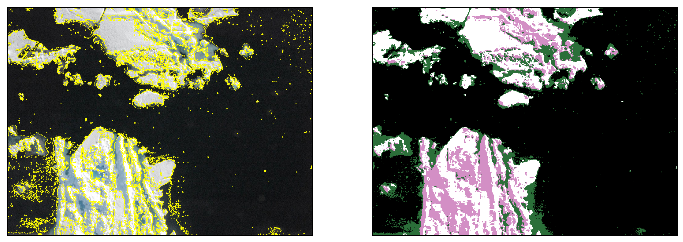

In [65]:
# Plot out the classification
fig2, ax = plt.subplots(1, 2, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'}, 
                        figsize=(12, 6))
ax[0].imshow(mark_boundaries(img, labeled_img))
ax[1].imshow(labeled_img, cm.cubehelix)
for a in ax:
    a.set_xticks(())
    a.set_yticks(())
plt.show()

## Use the analysis from the previous image (generated using unsupervised GMM learning) to train the classification of another sea ice image... 

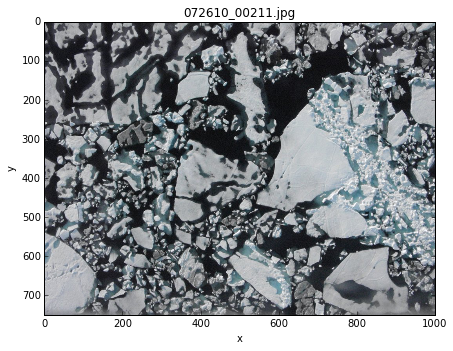

In [66]:
# Read in another sea ice image (from the same helicopter campaign)

imageName="072610_00211.jpg"
img2 = misc.imread(filePath+imageName)
fig6 = figure(figsize=(7, 6))
xlabel('x')
ylabel('y')
imshow(img2)
title(imageName)
plt.show()

In [67]:
# label using the previous GMM model
labeled_img6 = gmix.predict(img2.reshape((img2.shape[0]*img2.shape[1],3))). \
    reshape(img2.shape[0],img2.shape[1])

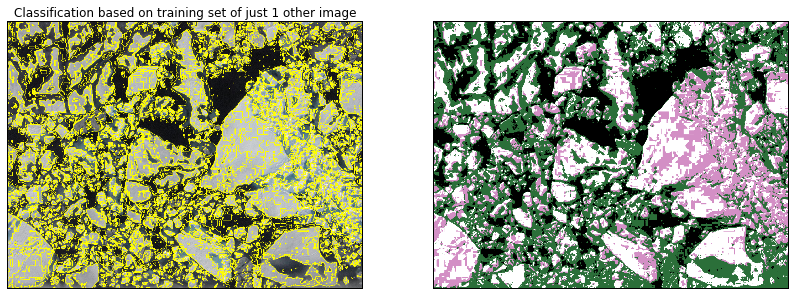

In [68]:
# Plot out this classification
fig7, ax = plt.subplots(1, 2, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'}, 
                        figsize=(14, 6))
ax[0].imshow(mark_boundaries(img2, labeled_img6))
ax[1].imshow(labeled_img6, cmap=cm.cubehelix)
ax[0].set_title("Classification based on training set of just 1 other image")
for a in ax:
    a.set_xticks(())
    a.set_yticks(())
plt.show()

Train the algorithm (GMM) with a number of images 

In [69]:
# Read in multiple images

#number of images we want to use from within the training directory
num_files=3

from glob import glob
files=glob(trainingPath+'*.jpg')
imgAll = misc.imread(files[0]).reshape((-1, 3))
print 'Num of files used: '+str(num_files)+'/'+str(size(files))
iterfiles = iter(files)
next(iterfiles)

# Concatenate images into one big image
for file in files[0:num_files]:
    imgT = misc.imread(file).reshape((-1, 3))
    imgAll=np.concatenate((imgT, imgAll))
print 'size of combined image:', imgAll.shape

Num of files used: 3/12
size of combined image: (3000000, 3)


In [70]:
gmixAll = mixture.GMM(n_components=iceTypes, covariance_type='full')
gmixAll.fit(imgAll)
#extract class means and cov
#this can be made a 'supervised' method by setting .means_ and .covars_ to mean/cov of samples
mean2 = gmixAll.means_
cov2 = gmixAll.covars_

In [71]:
gmixAll=sortGMM(gmixAll)
gmixAll.means_

array([[  18.25174706,   20.01029669,   22.64604514],
       [  47.65347645,   55.83239838,   58.30698368],
       [ 133.50560956,  150.7341413 ,  156.73655831],
       [ 201.35133238,  202.95648335,  204.88647615]])

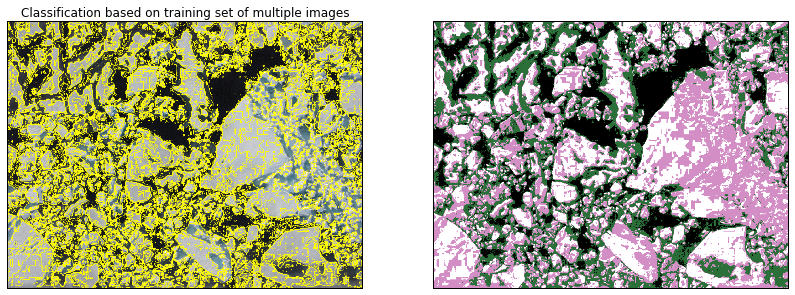

In [72]:
labeled_img7 = gmixAll.predict(img2.reshape((-1,3))). \
    reshape(img2.shape[0],img2.shape[1])
fig8, ax = plt.subplots(1, 2, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'}, 
                        figsize=(14, 6))
ax[0].imshow(mark_boundaries(img2, labeled_img7))
ax[1].imshow(labeled_img7, cmap=cm.cubehelix)
ax[0].set_title("Classification based on training set of multiple images")
for a in ax:
    a.set_xticks(())
    a.set_yticks(())
plt.show()

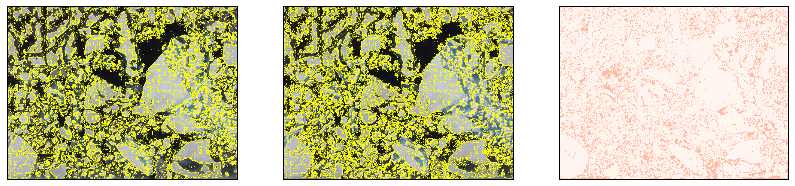

In [73]:
fig9, ax = plt.subplots(1, 3, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'}, 
                        figsize=(14, 6))
ax[0].imshow(mark_boundaries(img2, labeled_img6))
ax[1].imshow(mark_boundaries(img2, labeled_img7))
ax[2].imshow(labeled_img7-labeled_img6, cmap=cm.Reds, vmin=0, vmax=4)
for a in ax:
    a.set_xticks(())
    a.set_yticks(())
plt.show()


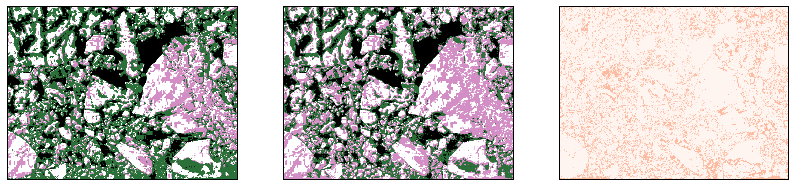

In [74]:
fig9, ax = plt.subplots(1, 3, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'}, 
                        figsize=(14, 6))
ax[0].imshow(labeled_img6, cmap=cm.cubehelix)
ax[1].imshow(labeled_img7, cmap=cm.cubehelix)
ax[2].imshow(labeled_img7-labeled_img6, cmap=cm.Reds, vmin=0, vmax=4)
for a in ax:
    a.set_xticks(())
    a.set_yticks(())
plt.show()

In [75]:
labeled_img7

array([[1, 1, 0, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ..., 
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [76]:
#test which is best - trained with one other image, multiple other images, or a supervised dataset.
# how to judge? Manually selecting I guess..